In [14]:
# 解压小麦数据集
!unzip -qd /home/aistudio/data/data15555 /home/aistudio/data/data140289/ImporfectWheat_photos.zip

replace /home/aistudio/data/data15555/发芽粒/4001_faya2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [15]:
#返回数据列表
import codecs
import os
import random
import shutil
from PIL import Image
import numpy
from tqdm import tqdm

train_ratio = 4.5 / 5 #随机选取90%的数据作为训练集，剩下10%做测试集

all_file_dir = '/home/aistudio/data/data15555'
class_list = [c for c in os.listdir(all_file_dir) if os.path.isdir(os.path.join(all_file_dir, c)) and not c.endswith('Set') and not c.startswith('.')]
class_list.sort()
print(class_list)

#数据字典
train_data = []
eval_data = []

label2id = {'发芽粒':0, '发霉粒':1, '病斑粒':2, '破损粒':3, '虫蚀粒':4}
id2label = {0:'发芽粒', 1:'发霉粒', 2:'病斑粒', 3:'破损粒',4:'虫蚀粒'}

for class_dir in class_list:
    image_path_pre = os.path.join(all_file_dir, class_dir)
    for file in os.listdir(image_path_pre):
        if random.uniform(0, 1) <= train_ratio: #小于等于0.9
            train_data.append([os.path.join(image_path_pre, file), label2id[class_dir] ])
        else:
            eval_data.append([os.path.join(image_path_pre, file), label2id[class_dir] ])

print(len(train_data))
print(len(eval_data))
print(eval_data[0])

random.shuffle(train_data)
random.shuffle(eval_data)
print(eval_data[0])

['发芽粒', '发霉粒', '病斑粒', '破损粒', '虫蚀粒']
1898
206
['/home/aistudio/data/data15555/发芽粒/4220_faya221.jpg', 0]
['/home/aistudio/data/data15555/虫蚀粒/2295_chongshi296.jpg', 4]


In [16]:
# 数据读取并进行预处理
import paddle
from paddle.vision.transforms import Compose, ColorJitter, Resize,Transpose, Normalize
import cv2
import numpy as np
from PIL import Image
from paddle.io import Dataset

#自定义的数据预处理函数，输入原始图像，输出处理后的图像，可以借用paddle.vision.transforms的数据处理功能
def preprocess(img):
    transform = Compose([
        Resize(size=(224, 224)), #把数据长宽像素调成224*224
        Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5], data_format='HWC'), #标准化
        Transpose(), #原始数据形状维度是HWC格式，经过Transpose，转换为CHW格式
        ])
    img = transform(img).astype("float32")
    return img


#自定义数据读取器
class Reader(Dataset):
    def __init__(self, data):
        super().__init__()
        #在初始化阶段，把数据集划分训练集和测试集。由于在读取前样本已经被打乱顺序，取20%的样本作为测试集，80%的样本作为训练集。
        self.samples = data

    def __getitem__(self, idx):
        #处理图像
        img_path = self.samples[idx][0] #得到某样本的路径
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = preprocess(img) #数据预处理--这里仅包括简单数据预处理，没有用到数据增强

        #处理标签
        label = self.samples[idx][1] #得到某样本的标签
        label = np.array([label], dtype="int64") #把标签数据类型转成int64
        return img, label

    def __len__(self):
        #返回每个Epoch中图片数量
        return len(self.samples)

#生成训练数据集实例
train_dataset = Reader(train_data)

#生成测试数据集实例
eval_dataset = Reader(eval_data)

#打印一个训练样本
print(len(train_dataset)) #1866*0.8=1492.8
#print(train_dataset[1136][0])
print(train_dataset[1136][0].shape)
print(train_dataset[1136][1])
print(train_data[1136])

1898
(3, 224, 224)
[2]
['/home/aistudio/data/data15555/病斑粒/1070_bingbanp71.jpg', 2]


No handles with labels found to put in legend.


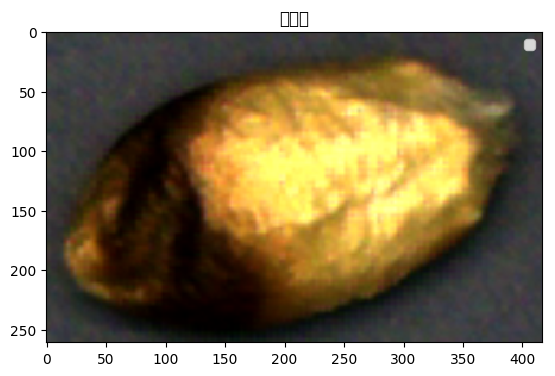

In [17]:
#输出其中一张图片并打印其对应类别
import os
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(train_data[1136][0])

fig, ax = plt.subplots() # 创建图实例
ax.imshow(img)
ax.set_title(id2label[train_data[1136][1]]) #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show()



In [18]:
import paddle
import paddle.nn as nn
from paddle.nn import Conv2D, MaxPool2D, AdaptiveAvgPool2D, Linear, ReLU, BatchNorm2D
import paddle.nn.functional as F

# ResNet18

In [19]:
#SE模块
class SENet(nn.Layer):
    def __init__(self, in_channel, ratio=16):
        super(SENet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2D(1)
        self.fc = nn.Sequential(
                nn.Linear(in_channel, in_channel // ratio),
                nn.ReLU(),
                nn.Linear(in_channel // ratio, in_channel),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        # print(x.shape)
        y = self.avg_pool(x).reshape([b, c])
        # print(y.shape)
        y = self.fc(y).reshape([b, c, 1, 1])
        # print(y.shape)
        return x * y

In [20]:
class Basicblock(paddle.nn.Layer):
    def __init__(self, in_channel, out_channel, stride = 1):
        super(Basicblock, self).__init__()
        self.stride = stride
        self.conv0 = Conv2D(in_channel, out_channel, 3, stride = stride, padding = 1)
        self.conv1 = Conv2D(out_channel, out_channel, 3, stride=1, padding = 1)
        self.conv2 = Conv2D(in_channel, out_channel, 1, stride = stride)
        self.bn0 = BatchNorm2D(out_channel)
        self.bn1 = BatchNorm2D(out_channel)
        self.bn2 = BatchNorm2D(out_channel)

    def forward(self, inputs):
        y = inputs
        x = self.conv0(inputs)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.bn1(x)
        if self.stride == 2:
            y = self.conv2(y)
            y = self.bn2(y)
        z = F.relu(x+y)
        return z

class Bottleneckblock(paddle.nn.Layer):
    def __init__(self, inplane, in_channel, out_channel, stride = 1, start = False):
        super(Bottleneckblock, self).__init__()
        self.stride = stride
        self.start = start
        self.conv0 = Conv2D(in_channel, inplane, 1, stride = stride)
        self.conv1 = Conv2D(inplane, inplane, 3, stride=1, padding=1)
        self.conv2 = Conv2D(inplane, out_channel, 1, stride=1)
        self.conv3 = Conv2D(in_channel, out_channel, 1, stride = stride)
        self.bn0 = BatchNorm2D(inplane)
        self.bn1 = BatchNorm2D(inplane)
        self.bn2 = BatchNorm2D(out_channel)
        self.bn3 = BatchNorm2D(out_channel)

    def forward(self, inputs):
        y = inputs
        x = self.conv0(inputs)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.start:
            y = self.conv3(y)
            y = self.bn3(y)
        z = F.relu(x+y)
        return z

class Resnet(paddle.nn.Layer):
    def __init__(self, num, bottlenet):
        super(Resnet, self).__init__()
        self.conv0 = Conv2D(3, 64, 7, stride=2)
        self.bn = BatchNorm2D(64)
        self.pool1 = MaxPool2D(3, stride=2)
        if bottlenet:
            self.layer0 = self.add_bottleneck_layer(num[0], 64, start = True)
            self.layer1 = self.add_bottleneck_layer(num[1], 128)
            self.layer2 = self.add_bottleneck_layer(num[2], 256)
            self.layer3 = self.add_bottleneck_layer(num[3], 512)
        else:
            self.layer0 = self.add_basic_layer(num[0], 64, start = True)
            self.layer1 = self.add_basic_layer(num[1], 128)
            self.layer2 = self.add_basic_layer(num[2], 256)
            self.layer3 = self.add_basic_layer(num[3], 512)
        self.pool2 = AdaptiveAvgPool2D(output_size = (1, 1))
        self.dropout=paddle.nn.Dropout(p=0.5) #Dropout值设为0.5
        self.fc1 = nn.Linear(512, 20) #fc为全连接层，与模型训练后为20个输出，要最后分5类
        self.se1 = SENet(20)
        self.fc2 = nn.Linear(20, 5) #两个全连接层实现20-5

    def add_basic_layer(self, num, inplane, start = False):
        layer = []
        if start:
            layer.append(Basicblock(inplane, inplane))
        else:
            layer.append(Basicblock(inplane//2, inplane, stride = 2))
        for i in range(num-1):
            layer.append(Basicblock(inplane, inplane))
        return nn.Sequential(*layer)

    def add_bottleneck_layer(self, num, inplane, start = False):
        layer = []
        if start:
            layer.append(Bottleneckblock(inplane, inplane, inplane*4, start = True))
        else:
            layer.append(Bottleneckblock(inplane, inplane*2, inplane*4, stride = 2, start = True))
        for i in range(num-1):
            layer.append(Bottleneckblock(inplane, inplane*4, inplane*4))
        return nn.Sequential(*layer)

    def forward(self, inputs):
        x = self.conv0(inputs)
        x = self.bn(x)
        x = self.pool1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)        
        x = self.pool2(x)
        x = paddle.reshape(x,shape=[-1,512])

        x = self.fc1(x)
        my_x,my_y = x.shape
        x = paddle.reshape(x,shape=[my_x,my_y,1,1])
        x = self.se1(x)
        x = paddle.reshape(x,shape=[my_x,my_y])
        x=F.relu(x) #使用relu函数激活
        x = self.fc2(x)
        return x


In [21]:
model1 = Resnet([2, 2, 2, 2], bottlenet = False)
paddle.summary(model1, (1, 3, 224, 224))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-77       [[1, 3, 224, 224]]   [1, 64, 109, 109]        9,472     
  BatchNorm2D-51    [[1, 64, 109, 109]]   [1, 64, 109, 109]         256      
   MaxPool2D-13     [[1, 64, 109, 109]]    [1, 64, 54, 54]           0       
     Conv2D-78       [[1, 64, 54, 54]]     [1, 64, 54, 54]        36,928     
  BatchNorm2D-52     [[1, 64, 54, 54]]     [1, 64, 54, 54]          256      
     Conv2D-79       [[1, 64, 54, 54]]     [1, 64, 54, 54]        36,928     
  BatchNorm2D-53     [[1, 64, 54, 54]]     [1, 64, 54, 54]          256      
   Basicblock-17     [[1, 64, 54, 54]]     [1, 64, 54, 54]           0       
     Conv2D-81       [[1, 64, 54, 54]]     [1, 64, 54, 54]        36,928     
  BatchNorm2D-55     [[1, 64, 54, 54]]     [1, 64, 54, 54]          256      
     Conv2D-82       [[1, 64, 54, 54]]     [1, 64, 54, 54]    

{'total_params': 11201338, 'trainable_params': 11191738}

# VGG网络

In [22]:
# 定义网络块
class ConvPool(paddle.nn.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,#1
                 num_filters, #2
                 filter_size,#3
                 pool_size,#4
                 pool_stride,#5
                 groups,#6
                 conv_stride=1, 
                 conv_padding=1,
                 ):
        super(ConvPool, self).__init__()  

        self._conv2d_list = []

        for i in range(groups):
            conv2d = self.add_sublayer(   #添加子层实例
                'bb_%d' % i,
                paddle.nn.Conv2D(         # layer
                in_channels=num_channels, #通道数
                out_channels=num_filters,   #卷积核个数
                kernel_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding = conv_padding,    #padding
                )
            )
            num_channels = num_filters
       
            self._conv2d_list.append(conv2d)

        self._pool2d = paddle.nn.MaxPool2D(
            kernel_size=pool_size,           #池化核大小
            stride=pool_stride               #池化步长
            )
        # print(self._conv2d_list)
    def forward(self, inputs):
        x = inputs
        for conv in self._conv2d_list:
            x = conv(x)
            x = paddle.nn.functional.relu(x)
        x = self._pool2d(x)
        return x




# 定义VGG网络结构
class VGGNet(paddle.nn.Layer):
  
    def __init__(self):
       super(VGGNet, self).__init__() 
       self.convpool01 = ConvPool(3,64,3,2,2,1)
       self.convpool02 = ConvPool(64,128,3,2,2,2)
       self.convpool03 = ConvPool(128,256,3,2,2,4)
       self.convpool04 = ConvPool(256,512,3,2,2,3)
       self.convpool05 = ConvPool(512,512,3,2,2,3)
       self.pool_5_shape = 512*7*7
       self.fc01 = paddle.nn.Linear(self.pool_5_shape,4096)
       self.se01 = SENet(4096)
       self.fc02 = paddle.nn.Linear(4096,2048)
       self.se02 = SENet(2048)
       self.fc03 = paddle.nn.Linear(2048,5)


    def forward(self, inputs, label=None):
        out = self.convpool01(inputs)
        out = self.convpool02(out)
        out = self.convpool03(out)
        out = self.convpool04(out)
        out = self.convpool05(out)
        out = paddle.reshape(out,shape=[-1,512*7*7])
        out = self.fc01(out)
        my_x, my_y = out.shape
        out = paddle.reshape(out,shape=[my_x,my_y,1,1])
        out = self.se01(out)
        out = paddle.reshape(out,shape=[my_x,my_y])
        out = self.fc02(out)
        my_x, my_y = out.shape
        out = paddle.reshape(out,shape=[my_x,my_y,1,1])
        out = self.se02(out)
        out = paddle.reshape(out,shape=[my_x,my_y])
        out = self.fc03(out)
        if label is not None:
          acc = paddle.metric.accuracy(input=out,label=label)
          return out,acc
        else:
          return out

In [23]:
model2 = paddle.Model(VGGNet())
model2.summary((1, 3, 224, 224))

--------------------------------------------------------------------------------
    Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-102       [[1, 3, 224, 224]]   [1, 64, 224, 224]        1,792     
    MaxPool2D-14     [[1, 64, 224, 224]]   [1, 64, 112, 112]          0       
    ConvPool-11       [[1, 3, 224, 224]]   [1, 64, 112, 112]          0       
     Conv2D-103      [[1, 64, 112, 112]]   [1, 128, 112, 112]      73,856     
     Conv2D-104      [[1, 128, 112, 112]]  [1, 128, 112, 112]      147,584    
    MaxPool2D-15     [[1, 128, 112, 112]]   [1, 128, 56, 56]          0       
    ConvPool-12      [[1, 64, 112, 112]]    [1, 128, 56, 56]          0       
     Conv2D-105       [[1, 128, 56, 56]]    [1, 256, 56, 56]       295,168    
     Conv2D-106       [[1, 256, 56, 56]]    [1, 256, 56, 56]       590,080    
     Conv2D-107       [[1, 256, 56, 56]]    [1, 256, 56, 56]       590,080    
     Conv2D-108       [[1, 256, 56, 56]]    [1, 25

{'total_params': 129061253, 'trainable_params': 129061253}

In [24]:
train_loader=paddle.io.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=4,use_shared_memory=True)
eval_loader =paddle.io.DataLoader(eval_dataset,batch_size=32,shuffle=True,num_workers=4,use_shared_memory=True)

model_vgg = VGGNet()
optimizer_vgg=paddle.optimizer.Adam(learning_rate=0.0001,weight_decay=0.01,parameters=model_vgg.parameters())
cre_vgg = nn.CrossEntropyLoss()

model_resnet = Resnet([2, 2, 2, 2], bottlenet = False)
optimizer_resnet = paddle.optimizer.Adam(learning_rate=0.0001,weight_decay=0.01,parameters=model_resnet.parameters())
cre_resnet = nn.CrossEntropyLoss()


loss_vgg_list = []
acc_vgg_list = []

loss_resnet_list = []
acc_resnet_list = []

acc_all_list = []

for epoch in range(20):
    total_loss_vgg = 0.
    total_acc_vgg = 0.
    total_loss_resnet = 0.
    total_acc_resnet = 0.
    total_acc = 0.

    model_vgg.train()
    model_resnet.train()

    for img,label in tqdm(train_loader):
        #输出维度
        #print(img.shape)#[32, 3, 224, 224]
        #print(label.shape)#[32, 1]

        y_pred_1=model_vgg(img)
        #print(y_pred_1.shape)#[32, 5]
        y_pred_2=model_resnet(img)
        blending_y_pred = y_pred_1 * 0.6 + y_pred_2 * 0.4

        loss_vgg=cre_vgg(y_pred_1,label.astype('int64'))
        loss_resnet=cre_resnet(y_pred_2,label.astype('int64'))

        #获取损失值 vgg
        total_loss_vgg+=loss_vgg.numpy()[0]
        #反向传播
        optimizer_vgg.clear_grad()
        loss_vgg.backward()
        optimizer_vgg.step()

        #获取损失值  resnet
        total_loss_resnet+=loss_resnet.numpy()[0]
        #反向传播
        optimizer_resnet.clear_grad()
        loss_resnet.backward()
        optimizer_resnet.step()

        #获取输出的最大值
        pred_1 = paddle.argmax(y_pred_1,axis=1)
        total_acc_vgg += paddle.sum(pred_1 == label)
        pred_2 = paddle.argmax(y_pred_2,axis=1)
        total_acc_resnet += paddle.sum(pred_2 == label)
        #print(pred_1.shape)[32]
        blending_y_pred = paddle.argmax(blending_y_pred,axis=1)
        total_acc += paddle.sum(blending_y_pred == label)

        
    #添加进列表中
    loss_vgg_list.append(total_loss_vgg)
    acc_vgg_list.append(total_acc_vgg.numpy()[0])

    loss_resnet_list.append(total_loss_resnet)
    acc_resnet_list.append(total_acc_resnet.numpy()[0])

    acc_all_list.append(total_acc.numpy()[0])
    print('Epoch{},Model_1 Loss:{},Model_1 ACC:{},Model_2  Loss:{},Model_2  ACC:{}, Blending_Model ACC:{}'.format(
            epoch, total_loss_vgg, total_acc_vgg.numpy()[0], total_loss_resnet, total_acc_resnet.numpy()[0], total_acc.numpy()[0]))

100%|██████████| 60/60 [00:10<00:00,  5.48it/s]


Epoch0,Model_1 Loss:109.90732002258301,Model_1 ACC:12666.0,Model_2  Loss:49.902826845645905,Model_2  ACC:12093.0, Blending_Model ACC:12479.0


100%|██████████| 60/60 [00:11<00:00,  5.07it/s]


Epoch1,Model_1 Loss:55.935344099998474,Model_1 ACC:12939.0,Model_2  Loss:17.455887012183666,Model_2  ACC:13291.0, Blending_Model ACC:13303.0


100%|██████████| 60/60 [00:10<00:00,  5.53it/s]


Epoch2,Model_1 Loss:48.70927903056145,Model_1 ACC:12975.0,Model_2  Loss:9.741058584302664,Model_2  ACC:13434.0, Blending_Model ACC:13401.0


100%|██████████| 60/60 [00:10<00:00,  5.49it/s]


Epoch3,Model_1 Loss:46.764121264219284,Model_1 ACC:13392.0,Model_2  Loss:9.507151905447245,Model_2  ACC:13429.0, Blending_Model ACC:13441.0


100%|██████████| 60/60 [00:11<00:00,  5.13it/s]


Epoch4,Model_1 Loss:37.67118459939957,Model_1 ACC:13445.0,Model_2  Loss:8.689538134261966,Model_2  ACC:13463.0, Blending_Model ACC:13606.0


100%|██████████| 60/60 [00:11<00:00,  5.41it/s]


Epoch5,Model_1 Loss:36.112953811883926,Model_1 ACC:13401.0,Model_2  Loss:6.00237830914557,Model_2  ACC:13704.0, Blending_Model ACC:13670.0


100%|██████████| 60/60 [00:11<00:00,  5.37it/s]


Epoch6,Model_1 Loss:31.71397227048874,Model_1 ACC:13288.0,Model_2  Loss:3.534776879940182,Model_2  ACC:13582.0, Blending_Model ACC:13572.0


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


Epoch7,Model_1 Loss:29.50280448794365,Model_1 ACC:13504.0,Model_2  Loss:2.130201338324696,Model_2  ACC:13706.0, Blending_Model ACC:13696.0


100%|██████████| 60/60 [00:10<00:00,  5.52it/s]


Epoch8,Model_1 Loss:29.5731710344553,Model_1 ACC:13363.0,Model_2  Loss:6.877180859446526,Model_2  ACC:13535.0, Blending_Model ACC:13559.0


100%|██████████| 60/60 [00:10<00:00,  5.56it/s]


Epoch9,Model_1 Loss:24.886411637067795,Model_1 ACC:13391.0,Model_2  Loss:3.58554367441684,Model_2  ACC:13635.0, Blending_Model ACC:13627.0


100%|██████████| 60/60 [00:11<00:00,  5.25it/s]


Epoch10,Model_1 Loss:21.822069361805916,Model_1 ACC:13508.0,Model_2  Loss:7.7068000617437065,Model_2  ACC:13483.0, Blending_Model ACC:13620.0


100%|██████████| 60/60 [00:10<00:00,  5.47it/s]


Epoch11,Model_1 Loss:23.20278190076351,Model_1 ACC:13540.0,Model_2  Loss:3.751133983489126,Model_2  ACC:13732.0, Blending_Model ACC:13807.0


100%|██████████| 60/60 [00:11<00:00,  5.43it/s]


Epoch12,Model_1 Loss:18.738278537988663,Model_1 ACC:13566.0,Model_2  Loss:5.008132733637467,Model_2  ACC:13555.0, Blending_Model ACC:13670.0


100%|██████████| 60/60 [00:11<00:00,  5.23it/s]


Epoch13,Model_1 Loss:23.730011507868767,Model_1 ACC:13443.0,Model_2  Loss:3.4645730783231556,Model_2  ACC:13673.0, Blending_Model ACC:13710.0


100%|██████████| 60/60 [00:10<00:00,  5.51it/s]


Epoch14,Model_1 Loss:18.63662924617529,Model_1 ACC:13603.0,Model_2  Loss:3.3719871202483773,Model_2  ACC:13545.0, Blending_Model ACC:13681.0


100%|██████████| 60/60 [00:11<00:00,  5.44it/s]


Epoch15,Model_1 Loss:18.03022238612175,Model_1 ACC:13577.0,Model_2  Loss:4.183677263557911,Model_2  ACC:13658.0, Blending_Model ACC:13740.0


100%|██████████| 60/60 [00:11<00:00,  5.00it/s]


Epoch16,Model_1 Loss:14.931692399084568,Model_1 ACC:13643.0,Model_2  Loss:3.56966648157686,Model_2  ACC:13697.0, Blending_Model ACC:13783.0


100%|██████████| 60/60 [00:11<00:00,  5.32it/s]


Epoch17,Model_1 Loss:20.81277745962143,Model_1 ACC:13393.0,Model_2  Loss:1.7069778766017407,Model_2  ACC:13659.0, Blending_Model ACC:13648.0


100%|██████████| 60/60 [00:11<00:00,  5.26it/s]


Epoch18,Model_1 Loss:17.64473520964384,Model_1 ACC:13436.0,Model_2  Loss:5.062988616991788,Model_2  ACC:13545.0, Blending_Model ACC:13655.0


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]

Epoch19,Model_1 Loss:13.998318433761597,Model_1 ACC:13575.0,Model_2  Loss:3.5424486263655126,Model_2  ACC:13552.0, Blending_Model ACC:13658.0


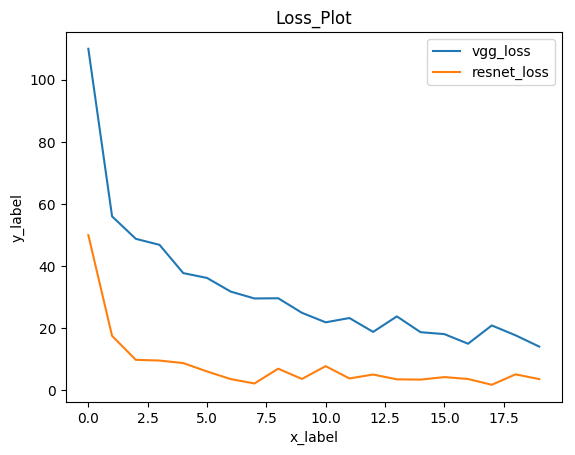

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() # 创建图实例
ax.plot(range(len(loss_vgg_list)), loss_vgg_list, label='vgg_loss')
ax.plot(range(len(loss_resnet_list)), loss_resnet_list, label='resnet_loss')
ax.set_xlabel('x_label') #设置x轴名称 x label
ax.set_ylabel('y_label') #设置y轴名称 y label
ax.set_title('Loss_Plot') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show()

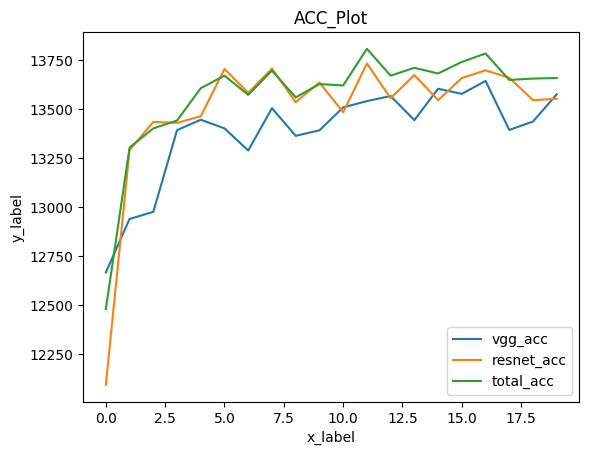

In [26]:
fig, ax = plt.subplots() # 创建图实例
ax.plot(range(len(acc_vgg_list)), acc_vgg_list, label='vgg_acc')
ax.plot(range(len(acc_resnet_list)), acc_resnet_list, label='resnet_acc')
ax.plot(range(len(acc_all_list)), acc_all_list, label='total_acc')
ax.set_xlabel('x_label') #设置x轴名称 x label
ax.set_ylabel('y_label') #设置y轴名称 y label
ax.set_title('ACC_Plot') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show()

In [28]:
#测试
model_vgg.eval()
model_resnet.eval()

total_acc_vgg = 0.
total_acc_resnet = 0.
total_acc = 0.

eval_loader =paddle.io.DataLoader(eval_dataset,batch_size=32,shuffle=True,num_workers=4,use_shared_memory=True)

for img,label in tqdm(eval_loader):
    y_pred_1=model_vgg(img)
    #print(y_pred_1.shape)#[32, 5]
    y_pred_2=model_resnet(img)
    blending_y_pred = y_pred_1 * 0.6 + y_pred_2 * 0.4

    #获取输出的最大值
    pred_1 = paddle.argmax(y_pred_1,axis=1)
    total_acc_vgg += paddle.sum(pred_1 == label)
    pred_2 = paddle.argmax(y_pred_2,axis=1)
    total_acc_resnet += paddle.sum(pred_2 == label)
    blending_y_pred = paddle.argmax(blending_y_pred,axis=1)
    total_acc += paddle.sum(blending_y_pred == label)

print('使用vgg模型得出正确结果为{},使用resnet模型得出正确结果为{},使用特征融合得出正确结果为{}'.format(
    total_acc_vgg.numpy()[0], total_acc_resnet.numpy()[0], total_acc.numpy()[0]
))

100%|██████████| 7/7 [00:01<00:00,  4.83it/s]

使用vgg模型得出正确结果为1329.0,使用resnet模型得出正确结果为1387.0,使用特征融合得出正确结果为1358.0
